### Causal Interpretation for Ames Housing Price

This notebook uses the Ames Housing dataset to showcase how we can interpret a blackbox model from both the correlation and causation perspective by leveraging the power of model interpretation tools like SHAP and EconML. This housing dataset collects house prices and characteristics for homes sold in Ames, Iowa from the period of 2006 to 2010. We start with a linear regression to build intuition. We then train a fine-tuned predictive ML model and use SHAP to better understand the correlations between features and target and which features are the strongest predictors. Finally, we train a separate causal model using EconML, which identifies features that have a direct causal effect on housing price, instead of just predicting the housing price given a set of characteristics.

Note: A previous version of this notebook used the Boston Housing dataset. Due to ethical concerns with the Boston Housing dataset, we have decided to redo the analysis on the similar Ames Housing dataset. More details can be found on the sklearn page for the Boston Housing dataset.

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap

### Linear Regression

In [2]:
from sklearn.datasets import fetch_openml

ames_housing = fetch_openml(name = 'house_prices', as_frame = True)

The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


In [3]:
ames_df = ames_housing.data
print(ames_df.shape)

(1460, 80)


#### Data Preprocessing

Minor feature engineering via feature creation/removal, and outlier removal

In [4]:
Xy = (
    ames_df
    .assign(SalePrice = ames_housing.target) # add target feature
    .set_index('Id')
    .loc[
        lambda df: df['MasVnrType'].notna() # drop outliers with missing detail in this column
    ]
    .loc[
        lambda df: df['Electrical'].notna() # drop outlier with missing electrical row
    ]
    .assign(
        AgeAtSale = lambda df: df['YrSold'].sub(df['YearBuilt']), # add interpretable year columns
        YearsSinceRemodel = lambda df: df['YrSold'].sub(df['YearRemodAdd']).clip(lower = 0), # clip lower for outlier

        HasDeck = lambda df: df['WoodDeckSF'].gt(0).map(int),
        HasPorch = lambda df:
        df[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]
        .gt(0)
        .max(axis = 1)
        .map(int),

        HasFireplace = lambda df: df['Fireplaces'].clip(upper = 1).map(int),
        HasFence = lambda df: df['Fence'].notna().map(int)
    )

    # drop year columns
    .drop(
        columns = [
            'GarageYrBlt', 'YearBuilt', 'YrSold', 'YearRemodAdd',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'FireplaceQu', 'Fireplaces',
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea'
        ]
    )
    .assign(LotFrontage = lambda df: df['LotFrontage'].fillna(0)) # fill missing with 0
    .fillna('NA') # rest of missing values are in categorical columns, so fill with NA category
    .assign(Intercept = 1) # add constant column for OLS
)

In [5]:
Xy

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,SalePrice,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,HasFireplace,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,208500,5,5,0,1,0,0,1
2,20,RL,80.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,181500,31,31,1,0,1,0,1
3,60,RL,68.0,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,223500,7,6,0,1,1,0,1
4,70,RL,60.0,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,140000,91,36,0,1,1,0,1
5,60,RL,84.0,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,250000,8,8,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,175000,8,7,0,1,1,0,1
1457,20,RL,85.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,210000,32,22,1,0,1,1,1
1458,70,RL,66.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,266500,69,4,0,1,1,1,1


Identify categorical columns for one hot encoding

In [6]:
categorial = list(
    Xy.apply(
        lambda series : series.dtype
    ).loc[
        lambda df : df.eq('object')
    ].index
) + ['MSSubClass']

In [7]:
X = Xy.drop(['SalePrice'], axis = 1)
X_ohe = X.pipe(
    pd.get_dummies, prefix_sep = '_OHE_', columns = categorial, dtype = 'uint8'
)
y = Xy['SalePrice'] # target

Train a linear regression using statsmodels

In [8]:
model = sm.OLS(y, X_ohe).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     59.41
Date:                Wed, 23 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:20:48   Log-Likelihood:                -16565.
No. Observations:                1451   AIC:                         3.362e+04
Df Residuals:                    1206   BIC:                         3.491e+04
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage           

### Train a fine tuned predictive ML Model

Now we train a Random Forest Regression Model and use Grid search to do model tuning

In [9]:
# split data into train and test
from sklearn.model_selection import train_test_split

x_train_ohe, x_test_ohe, x_train, x_test, y_train, y_test = train_test_split(
    X_ohe, X, y, test_size = 0.2, random_state = 42
)

In [10]:
# train a Random Forest regression model
forest_regression = RandomForestRegressor(
    n_estimators = 1000,
    random_state = 42,
    criterion = 'squared_error',
    max_depth = 20,
    min_samples_split = 2,
    min_samples_leaf = 2
)

In [11]:
forest_regression.fit(x_train_ohe, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=1000,
                      random_state=42)

In [12]:
print(f'Test set score : {forest_regression.score(x_test_ohe, y_test) * 100 : .2f}%')

Test set score :  89.23%


### Correlation Interpretation

- Feature importance - SHAP Values

We explain this ML model by understanding the top important features to predict the housing price, internally using shap value.

In [13]:
# use interventional approach

background = shap.maskers.Independent(x_train_ohe, max_samples = 100)
explainer = shap.TreeExplainer(
    forest_regression, 
    data = background, 
    feature_names = X_ohe.columns
)
shap_values = explainer(x_test_ohe)

 98%|===================| 286/291 [00:58<00:01]        

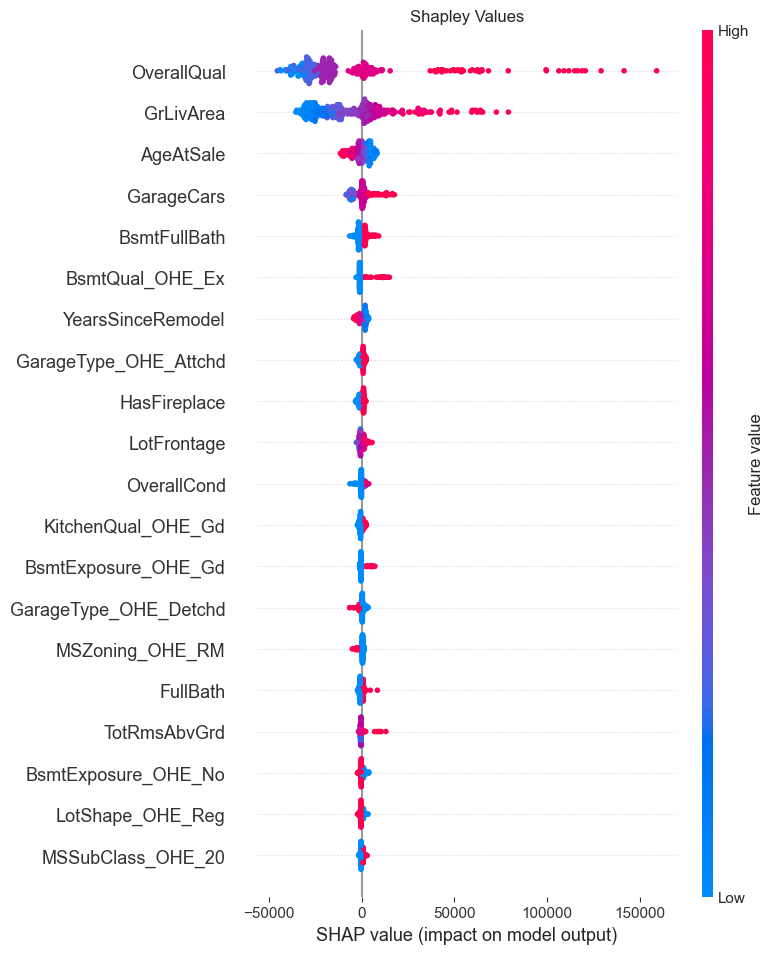

In [14]:
# plot the feature importances
shap.summary_plot(shap_values, x_test_ohe, show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

From the summary plot above, we could see the **most important features** sorted by their importance level. It tells us that houses that measure high in overall quality, square footage, and are also relatively new will have a higher housing price.

### Causal Interpretation

#### Direct Causal Effect -- Do certain house characteristics have a direct effect on home value?

We've seen which features are good predictors of home value, but are these features also causally signficiant? Below we use the CausalAnalysis class to assess the causal effects of certain house characteristics on home value.

In [15]:
# order feature names according to shap values
vals = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(shap_values.feature_names, vals)), columns = ["features", "importance"]
)
feature_importance.sort_values(by = ['importance'], ascending = False, inplace = True)

In [16]:
# keep top k features for causal analysis
k = 5
sorted_features = feature_importance['features']
top_k_features = list(sorted_features.values)[:5]

In [26]:
from econml.solutions.causal_analysis import CausalAnalysis

# initialize heterogeneity features
hetero_cols = ['AgeAtSale', 'MSZoning']

ca = CausalAnalysis(
    feature_inds = top_k_features + [
        'HasFireplace',
        'HasPorch',
        'HasDeck'
    ],
    categorical = categorial + ['HasFireplace', 'HasPorch', 'HasDeck', 'HasFence'],
    heterogeneity_inds = hetero_cols,
    classification = False,
    nuisance_models = 'automl',
    heterogeneity_model = 'linear',
    n_jobs = -1,
    random_state = 42,
    upper_bound_on_cat_expansion = 6
)

In [27]:
import warnings
warnings.filterwarnings('ignore')

ca.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 136
[LightGBM] [Info] Start training from score 182041.199224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 773, number of used features: 135
[LightGBM] [Info] Start training from score 36.727038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 149
[LightGBM] [Info] Start training from score 0.403017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 149
[LightGBM] [Info] Start training from score 36.93

Co-variance matrix is underdetermined. Inference will be invalid!


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 928, num

Co-variance matrix is underdetermined. Inference will be invalid!


In [28]:
# get global causal effect ordered by causal importance (pvalue)
global_summ = ca.global_causal_effect(alpha = 0.05)
global_summ.sort_values(by="p_value")

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverallQual,num,9980.509318,1828.396773,5.458612,4.798700e-08,6396.917494,13564.101142
GarageCars,num,14731.876099,3288.550177,4.479748,7.473121e-06,8286.436191,21177.316007
HasFireplace,1v0,6244.658433,1664.303327,3.752116,1.753486e-04,2982.683852,9506.633013
BsmtFullBath,num,8537.574244,3001.624276,2.844318,4.450659e-03,2654.498768,14420.649719
GrLivArea,num,31.559559,17.717150,1.781300,7.486346e-02,-3.165417,66.284534
AgeAtSale,num,-237.354197,155.141325,-1.529922,1.260359e-01,-541.425606,66.717213
HasPorch,1v0,2624.961455,2105.216779,1.246884,2.124400e-01,-1501.187612,6751.110523
HasDeck,1v0,2021.081968,1805.666793,1.119300,2.630124e-01,-1517.959915,5560.123850


The table above sorts the features by causal significance (p value). If we compare the causal summary table to the ordering of the SHAP feature importances plot, we notice that for the most part the top predictive features are also causally significant. For example, **OverallQual** is the most predictive feature according to SHAP, and is also the most causally signficant. However, in contrast, **AgeAtSale** is a good predictor, but not very causally significant. This could perhaps be explained by the idea that even though older houses are correlated with low quality characteristics, once you control for these characteristics, house age by itself is not causally significant.

#### Helper funstion to plot error bar

In [29]:
def errorbar(res, figsize):
    xticks = res.index.get_level_values(0)
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xticks = [
        "{}***".format(t)
        if p < 1e-6
        else ("{}**".format(t) if p < 1e-3 else ("{}*".format(t) if p < 1e-2 else t))
        for t, p in zip(xticks, res["p_value"])
    ]
    plot_title = "Direct Causal Effect of Each Feature with 95% Confidence Interval, "
    fig, ax = plt.subplots(figsize = figsize)
    plt.errorbar(
        np.arange(len(xticks)),
        res["point"],
        yerr=[lowererr, uppererr],
        fmt="o",
        capsize=5,
        capthick=1,
        barsabove=True,
    )
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)
    ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
    plt.xticks(np.arange(len(xticks)), xticks, rotation=45)
    plt.title(plot_title)
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")
    plt.show()

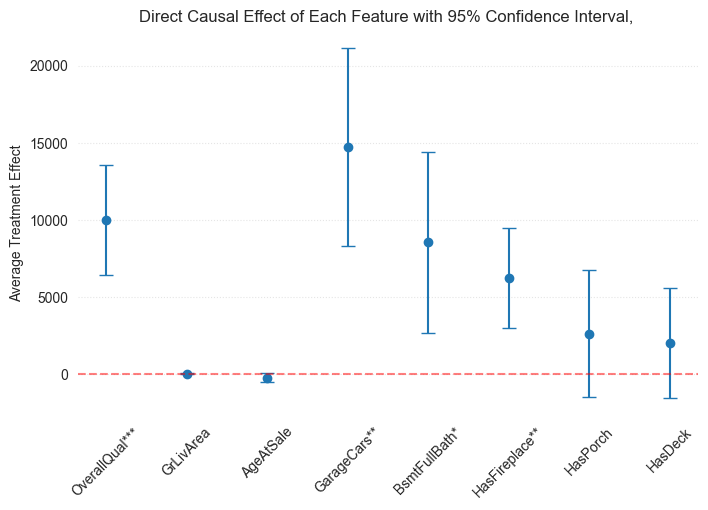

In [30]:
errorbar(global_summ, figsize = (8, 5))

We learn the **Average Treatment Effect (ATE)** for certain house characteristics (e.g. having a fireplace), assuming they are the treatment. The error bar above is ordered by **feature importance**, and the summary table above is ordered by **causal significance** (p-value). Notice they are not in the exact same order. For example, the second most predictive feature, GrLivArea (total square footage), is only the fourth most causally significant feature.

#### Segmentation -- How do different type of houses respond differently to having a fireplace?

From the analysis above, we learned the direct effect of a few different house amenities on housing price at an average level. However, the effect of these house amenities on house price may vary by features like home age and zoning classification. In the following section, we are going to use the presence of a fireplace as an example to learn how different type of houses may increase in value with the addition of a fireplace.

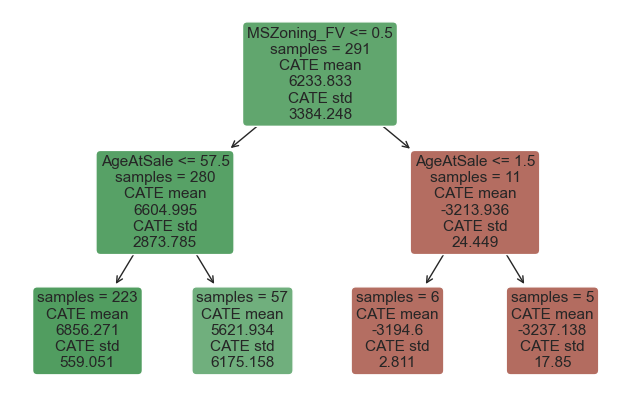

In [31]:
plt.figure(figsize = (8, 5))
ca.plot_heterogeneity_tree(
    x_test,
    "HasFireplace",
    max_depth=2,
    min_impurity_decrease=1e-6,
    min_samples_leaf = 5
)

From the global level, we know that the ATE of having a fireplace is 4.4k, which means on average that having a fireplace will raise the housing price by $4.4k. In the shallow tree above, we can see although overall fireplaces already have a positive effect on housing price, the effect is even more dramatic on houses older than 75 years old.

#### Policy Analysis -- What is the best policy considering cost?

To take a step further, we'd like to know the sub-population where the treatment effect will still be positive after taking cost into consideration. Assuming the average cost of adding a fireplace is $2,500, let us see what kind of houses have a housing price that will increase more than their cost.

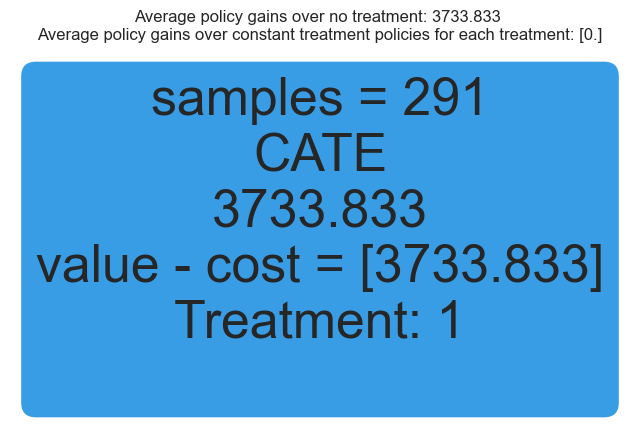

In [34]:
plt.figure(figsize = (8, 5))
ca.plot_policy_tree(
    x_test,
    "HasFireplace",
    treatment_costs=2500,
    max_depth=2,
    min_samples_leaf = 5
)

You could see if we follow the recommended policy above, on average, the housing price will increase by 2,356 compared with no fireplace added. Similarly, it will increase by 465 compared with adding a fireplace for every house. To be more detailed, we could also output the individualized policy. In the following table, we will only print the top five houses ordered by policy gains.

In [35]:
ca.individualized_policy(
    x_test,
    "HasFireplace",
    n_rows=5,
    treatment_costs=2500,
    alpha=0.1,
)

,Treatment,Effect of treatment,Effect of treatment lower bound,Effect of treatment upper bound,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,...,MoSold,SaleType,SaleCondition,AgeAtSale,YearsSinceRemodel,HasDeck,HasPorch,Current treatment,HasFence,Intercept
Id,,,,,,,,,,,,,,,,,,,,,
952,1,12475.499822,-7181.466806,32132.466451,20,RH,60.0,Pave,NA,Reg,...,7,WD,Abnorml,41,41,1,0,0,1,1
914,1,12374.125452,-7224.028445,31972.279349,90,RH,82.0,Pave,NA,Reg,...,8,WD,Normal,58,57,0,0,0,0,1
384,1,12236.971893,-7612.583441,32086.527227,45,RH,60.0,Pave,NA,Reg,...,10,WD,Normal,81,59,0,1,0,0,1
1235,1,12141.560721,-8100.692236,32383.813678,70,RH,55.0,Pave,NA,Reg,...,11,WD,Abnorml,97,58,0,1,0,0,1
886,0,5744.293746,-5606.666228,17095.253720,120,FV,50.0,Pave,NA,IR1,...,1,CWD,Abnorml,9,8,1,1,1,0,1


Note that here the `effect of treatment` is the treatment effect of selecting one of the discrete treatment values minus the cost. In the treament column, 1 corresponds to having a fireplace, and 0 corresponds to no fireplace.

### What If Analysis - How does the overall housing price change if every home had a fireplace?

The causal analysis tool could also answer **what if** types of questions. For a given treatment, we'd also like to know the **counterfactuals** if we intervene it in a different way. In the example below, we will learn how the overall housing price changes if every house in Ames had a fireplace.

In [36]:
whatif_df = x_test.loc[
    lambda df : df['HasFireplace'].eq(0)
]
whatif_y = y_test.loc[whatif_df.index]

In [37]:
counterfactuals = ca.whatif(
    whatif_df,
    whatif_df['HasFireplace'].add(1).clip(upper = 1),
    'HasFireplace',
    whatif_y
)

In [38]:
whatif_y.mean() # current average housing price on test set

142930.81944444444

In [39]:
counterfactuals['point_estimate'].mean() # average housing price with one more room on test set

149020.56470833335

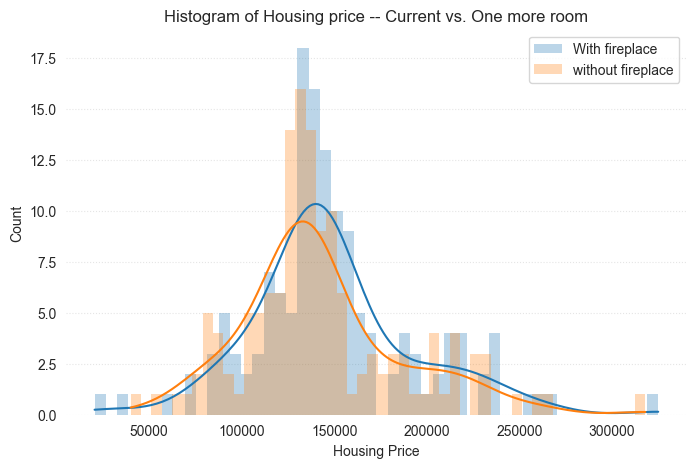

In [54]:
# distribution comparison
import seaborn as sns
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(
    counterfactuals.point_estimate, 
    label = 'With fireplace', 
    alpha = 0.3,
    edgecolor = 'none',
    bins = 50,
    kde = True,
    #weights = np.ones(len(whatif_y)) / len(whatif_y),
    ax = ax
)
sns.histplot(
    whatif_y,
    label = 'without fireplace',
    alpha = 0.3,
    edgecolor = 'none',
    bins = 50,
    kde = True,
    #weights = np.ones(len(whatif_y)) / len(whatif_y),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.xlabel('Housing Price')
plt.title('Histogram of Housing price -- Current vs. One more room')
plt.show()

From the summary table we could see overall if we add a fireplace to houses without fireplaces in the test set, the average housing price for those houses will increase by about $5k. And the histrogram shows a comparison between the current housing price distribution and the counterfactuals ditribution if we added a fireplace to the fireplace-less houses in the test set.

### Cohort Analysis -- What is the causal effect on a new dataset?

The CausalAnalysis class can also help us learn the global and local causal effect of a new dataset given a trained model. From the two tables below, you can see the global effect on the test set is similar to that of the training set. And calculating the local effect gives you the heterogeneous treatment effect for each observation.

In [56]:
# global effect on new dataset
ca.cohort_causal_effect(x_test)

,,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,feature_value,,,,,,
OverallQual,num,10104.712101,1917.590424,5.269484,1.368078e-07,6346.303934,13863.120269
GrLivArea,num,29.515471,19.193001,1.537825,1.240915e-01,-8.102120,67.133063
AgeAtSale,num,-242.373303,148.590036,-1.631154,1.028577e-01,-533.604422,48.857816
GarageCars,num,14833.036699,3493.696494,4.245657,2.179539e-05,7985.517398,21680.555999
BsmtFullBath,num,8579.110542,3259.644512,2.631916,8.490485e-03,2190.324696,14967.896388
HasFireplace,1v0,6233.833136,1705.288183,3.655589,2.565919e-04,2891.529713,9576.136558
HasPorch,1v0,2537.471466,2290.479610,1.107834,2.679335e-01,-1951.786078,7026.729009
HasDeck,1v0,2044.952730,1900.761983,1.075859,2.819901e-01,-1680.472300,5770.377759


In [57]:
# local effect on new dataset
ca.local_causal_effect(x_test)

point       stderr     zstat  \
sample feature      feature_value                                        
0      OverallQual  num            11626.716353  3568.270958  3.258361   
       GrLivArea    num               11.059141    39.352156  0.281030   
       AgeAtSale    num             -286.001225   150.706770 -1.897733   
       GarageCars   num            18376.771116  6985.323159  2.630769   
       BsmtFullBath num             9914.526497  7130.500128  1.390439   
...                                         ...          ...       ...   
290    GarageCars   num            12634.682265  2515.941024  5.021852   
       BsmtFullBath num             8763.043174  2499.950492  3.505287   
       HasFireplace 1v0             6647.354405  2054.360246  3.235730   
       HasPorch     1v0             1799.018553  2104.684807  0.854769   
       HasDeck      1v0             3388.138525  1987.055395  1.705105   

                                        p_value     ci_lower      ci_upper  
sample feature      feature_value                                           
0      OverallQual  num            1.120576e-03  4633.033789  18620.398917  
       GrLivArea    num            7.786873e-01   -66.069668     88.187949  
       AgeAtSale    num            5.773125e-02  -581.381065      9.378616  
       GarageCars   num            8.519194e-03  4685.789304  32067.752927  
       BsmtFullBath num            1.643956e-01 -4060.996946  23890.049941  
...                                         ...          ...           ...  
290    GarageCars   num            5.117574e-07  7703.528470  17565.836060  
       BsmtFullBath num            4.561158e-04  3863.230248  13662.856101  
       HasFireplace 1v0            1.213322e-03  2620.882311  10673.826499  
       HasPorch     1v0            3.926792e-01 -2326.087868   5924.124974  
       HasDeck      1v0            8.817480e-02  -506.418486   7282.695535  

[2328 rows x 6 columns]